<a href="https://colab.research.google.com/github/KotagiriRohan/MicroGrad/blob/main/Micro_gradient_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import random

In [185]:
def draw_graph(root):
    dot = graphviz.Digraph(comment="Connection Graph", graph_attr={'rankdir': 'LR'})
    nodes = set()

    def build(node):
        if node not in nodes:
            nodes.add(node)
            dot.node(name=str(id(node)), label="{%s| data %.4f | grad %.4f }" % (node.lable,node.data, node.grad), shape='record')
            if node.op:
                dot.node(name=str(id(node)) + node.op, label=node.op)
                dot.edge(str(id(node)) + node.op, str(id(node)))
            for child in node.prev:
                dot.edge(str(id(child)), str(id(node)) + node.op)
                build(child)

    build(root)
    return dot


class Value:
    def __init__(self, data, children=(), op='', lable=''):
        self.data = data
        self.prev = set(children)
        self.lable = lable
        self.grad = 0.0
        self._backward = lambda: None
        self.op = op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):  # self / other
        return self * other ** -1

    def __pow__(self, power, modulo=None):
        assert isinstance(power, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** power, (self,), f'**{power}')

        def _backward():
            self.grad += (power * self.data**(power-1)) * out.grad

        out._backward = _backward
        return out

    def __neg__(self):  # -self
        return self * Value(-1, lable="negitive")

    def __radd__(self, other): # other + self
        return self + other

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data})" #, children={self.prev}

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def tanh(self):

        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out


    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()



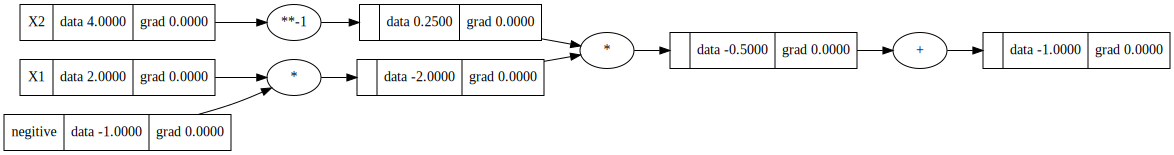

In [186]:
x = -Value(2, lable="X1") / Value(4,lable="X2")
y = x + x
draw_graph(y)

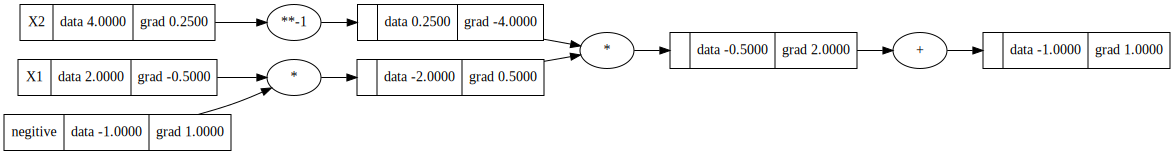

In [187]:
y.backward()
draw_graph(y)

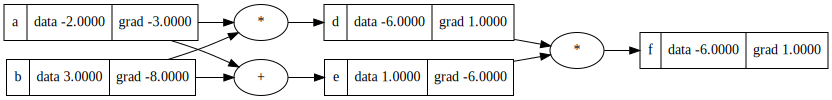

In [188]:
a = Value(-2.0, lable='a')
b = Value(3.0, lable='b')
d = a * b    ; d.lable = 'd'
e = a + b    ; e.lable = 'e'
f = d * e    ; f.lable = 'f'

f.backward()

draw_graph(f)

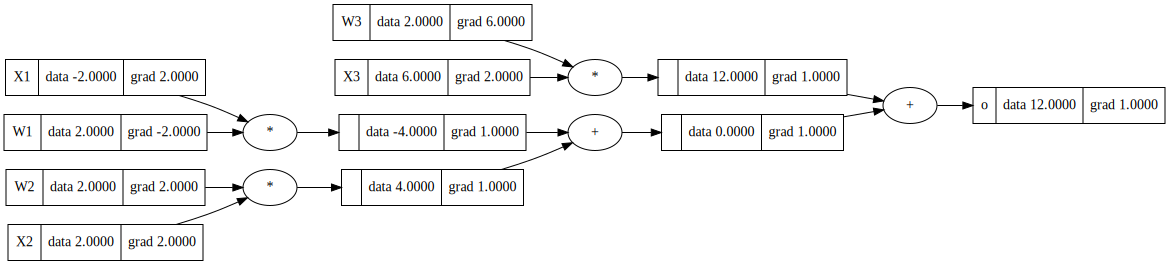

In [189]:
X1 = Value(-2.0, lable='X1')
X2 = Value(2.0, lable='X2')
X3 = Value(6.0, lable='X3')
W1 = Value(2.0, lable='W1')
W2 = Value(2.0, lable='W2')
W3 = Value(2.0, lable='W3')

o = X1*W1 +  X2*W2 +  X3*W3 ; o.lable = 'o'

o.backward()

draw_graph(o)

In [190]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum(wi*xi for wi, xi in zip(self.w, x))+ self.b
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [191]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9236209983390402)

In [192]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.9997713898834462),
 Value(data=-0.752778906609623),
 Value(data=0.43862721242944475)]

In [193]:
x = [2.0, 3.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.12033837369129927)

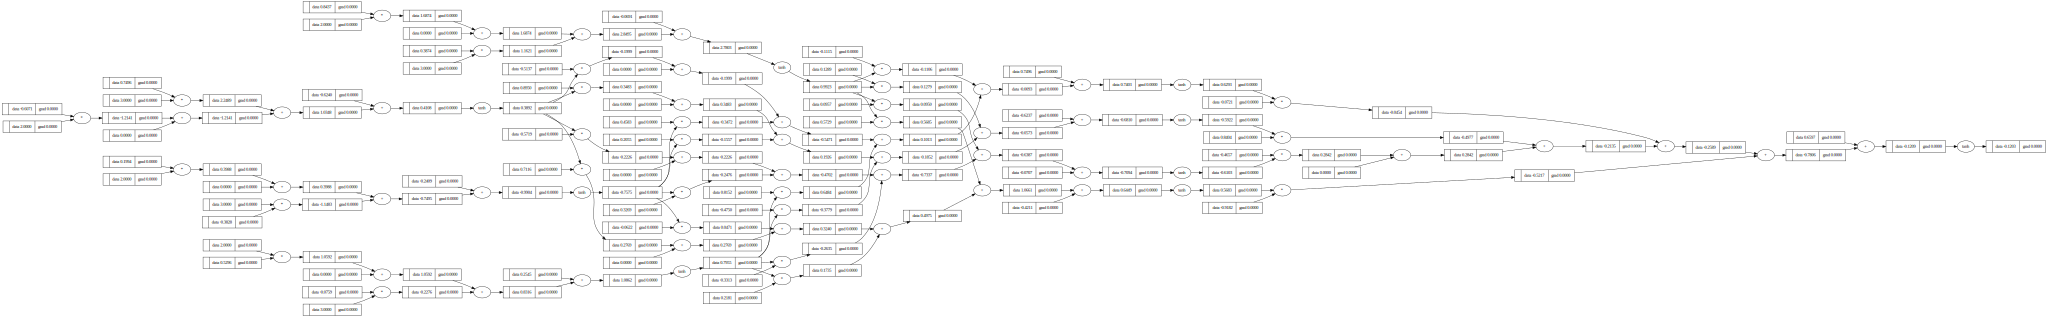

In [194]:
draw_graph(n(x))

In [229]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
n = MLP(3, [4,4,1])


In [267]:
for i in range(500):
    ypred = [n(x) for x in xs]
    loss = sum([(yout-y)**2 for y, yout in zip(ys, ypred)])
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    print("loss ",i," :",loss)
    for p in n.parameters():
        p.data += -0.1*p.grad


loss  0  : Value(data=9.027655577462549e-05)
loss  1  : Value(data=9.02484569697228e-05)
loss  2  : Value(data=9.022037546874537e-05)
loss  3  : Value(data=9.019231125578206e-05)
loss  4  : Value(data=9.016426431492205e-05)
loss  5  : Value(data=9.013623463027539e-05)
loss  6  : Value(data=9.010822218598536e-05)
loss  7  : Value(data=9.008022696619067e-05)
loss  8  : Value(data=9.005224895507403e-05)
loss  9  : Value(data=9.002428813681983e-05)
loss  10  : Value(data=8.999634449564537e-05)
loss  11  : Value(data=8.99684180157744e-05)
loss  12  : Value(data=8.994050868145763e-05)
loss  13  : Value(data=8.991261647697017e-05)
loss  14  : Value(data=8.98847413865863e-05)
loss  15  : Value(data=8.985688339462338e-05)
loss  16  : Value(data=8.982904248540373e-05)
loss  17  : Value(data=8.980121864327569e-05)
loss  18  : Value(data=8.977341185259514e-05)
loss  19  : Value(data=8.974562209775457e-05)
loss  20  : Value(data=8.971784936314851e-05)
loss  21  : Value(data=8.969009363320503e-05)
l

In [268]:
ypred

[Value(data=0.9966494785065226),
 Value(data=-0.996636708536204),
 Value(data=-0.9948616687448684),
 Value(data=0.9945980990605127)]